In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from liquidity.util.utils import compute_returns

from powerlaw_function.powerlaw_function import Fit

from hurst_exponent.util.utils import interpret_hurst
from hurst_exponent.acf import linear_acf, nonlinear_acf
from hurst_exponent.hurst_exponent import standard_hurst, generalized_hurst

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Number of lags for the autocorrelation functions
ACF_RANGE = 1001

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')


stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

# 1. Returns

In [5]:
# Compute percentage returns and absolute normalised (by its volatility) returns.
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']


In [6]:
returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'APPL': appl_returns
}

## 1.1. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.

- **H1:** The time series is stationary.

- **Note:**
  - If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.


In [7]:
# ADF test
def print_ADF_test_results_for_series(sample, name: str, alpha=0.05):
    # Convert list to pandas Series if necessary
    if isinstance(sample, list):
        sample = pd.Series(sample)

    # Replace inf and -inf with nan
    sample.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop nan values
    sample.dropna(inplace=True)

    print(name)
    adf, p, usedlag, nobs, cvs, aic = adfuller(sample)
    adf_results_string = 'ADF: {:.2f}\np-value: {:.2f},\nN: {}, \ncritical values: {}'
    print(adf_results_string.format(adf, p, nobs, cvs))

    # Interpretation
    if p < alpha:
        print("We reject the null hypothesis at a significance level of {}.".format(alpha))
        print("The time series appears to be stationary.")
    else:
        print("We cannot reject the null hypothesis at a significance level of {}.".format(alpha))
        print("The time series appears to be non-stationary.")

    print('\n')

In [ ]:
for stock, data in returns.items():
    print_ADF_test_results_for_series(data, stock)

TSLA
ADF: -385.64
p-value: 0.00,
N: 757334, 
critical values: {'1%': -3.43035863466075, '5%': -2.8615438164212765, '10%': -2.5667720313411375}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -377.43
p-value: 0.00,
N: 1015004, 
critical values: {'1%': -3.4303564426510023, '5%': -2.861542847579095, '10%': -2.5667715156617783}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX


## 1.2. Autocorrelation Function

There appears to be a clear difference between linear and nonlinear ACFs. If our data doesn’t contain significant non-linear patterns, both Pearson and Kendall methods could end up providing similar results.

**Key Points:**
- The **Kendall correlation** would detect non-linear relationships if they exist.
- If no non-linear relationships exist, it would just mirror the results of the Pearson correlation.
- Given this behavior, it’s best to use **Kendall** in case a non-linear relation holds for some data in our sample.


In [7]:
# Compute linear and nonlinear ACF
linear_acf_results = {}
nonlinear_acf_results = {}

for stock, series in returns.items():
    linear_acf_results[stock] = linear_acf(series, ACF_RANGE)
    nonlinear_acf_results[stock] = nonlinear_acf(series, ACF_RANGE, )

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


In [8]:
# Save data for lazy loading
import pickle
pickle.dump(linear_acf_results, open("returns_linear_acfs.pkl", "wb"))
pickle.dump(nonlinear_acf_results, open("returns_nonlinear_acfs.pkl", "wb"))
linear_acfs = pickle.load(open("returns_linear_acfs.pkl", "rb"))
nonlinear_acfs = pickle.load(open("returns_nonlinear_acfs.pkl", "rb"))

In [9]:
def plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs):

    linear_acf = linear_acfs[stock_name]
    nonlinear_acf = nonlinear_acfs[stock_name]

    plt.figure(figsize=(14, 4))

    # Original scale
    plt.subplot(1, 3, 1)
    plt.plot(range(ACF_RANGE), linear_acf, label='Linear')  # Change here
    plt.plot(range(ACF_RANGE), nonlinear_acf, label='Nonlinear', color='green')  # And here
    plt.grid(False)
    plt.legend(frameon=False)

    # log scale
    plt.subplot(1, 3, 2)
    plt.plot(range(ACF_RANGE), linear_acf, label='Linear')  # Change here
    plt.plot(range(ACF_RANGE), nonlinear_acf, label='Nonlinear', color='green')  # And here
    plt.grid(False)
    plt.loglog()
    plt.legend(frameon=False)
    plt.suptitle(f'Linear vs nonlinear ACF across lags for {stock_name} MO Returns')

    # Difference
    plt.subplot(1, 3, 3)
    difference = [x1-x2 for x1, x2 in zip(linear_acf, nonlinear_acf)]
    plt.plot(range(ACF_RANGE), difference, label="Difference", color='red')
    plt.legend(frameon=False)
    plt.grid(False)
    plt.suptitle(f'Linear vs nonlinear ACF across lags for {stock_name} MO Returns')

    print(f'{stock_name} Max difference: {max(difference)}')

    plt.show()

TSLA Max difference: 0.0014872265680442105


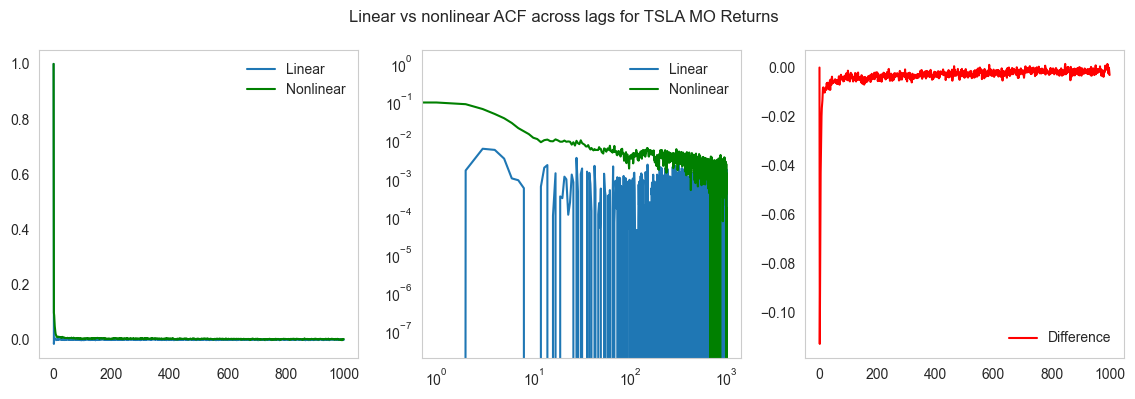

MSFT Max difference: 0.021027382367602113


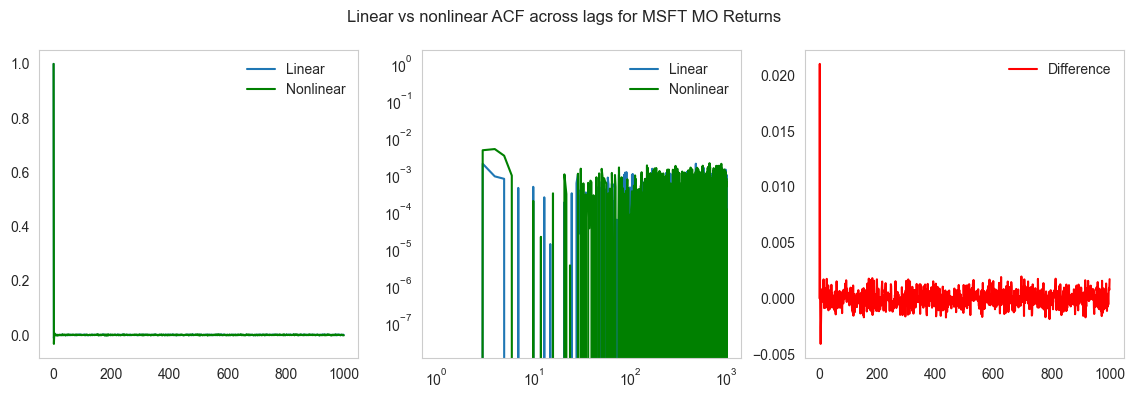

AMZN Max difference: 2.220446049250313e-16


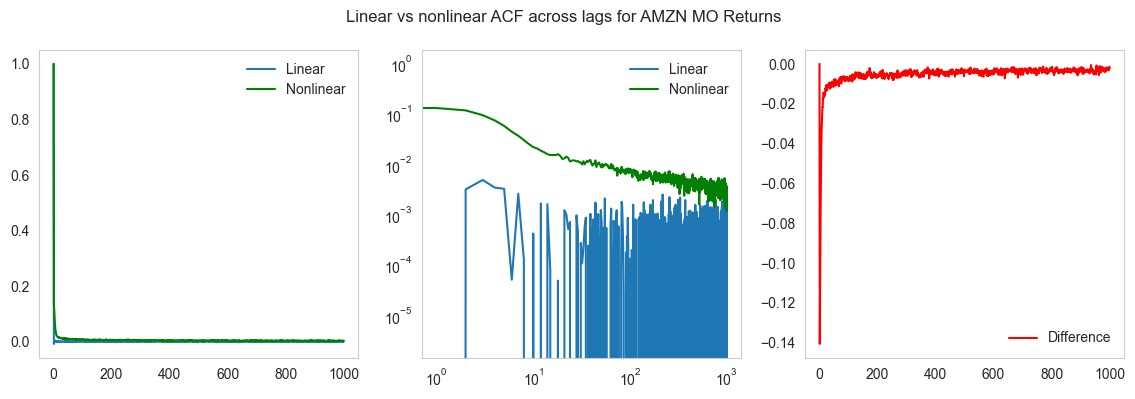

NFLX Max difference: 0.001640098670611175


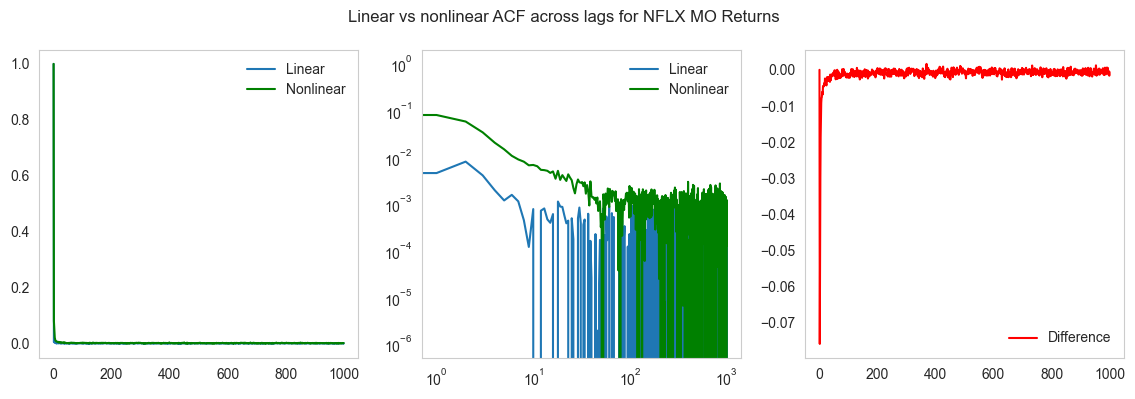

EBAY Max difference: 0.02629526705388381


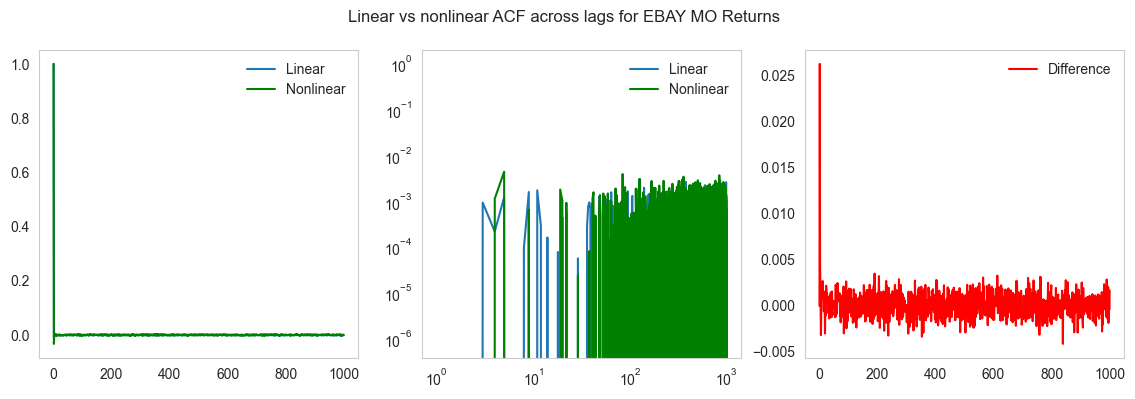

APPL Max difference: 0.0008223723498360199


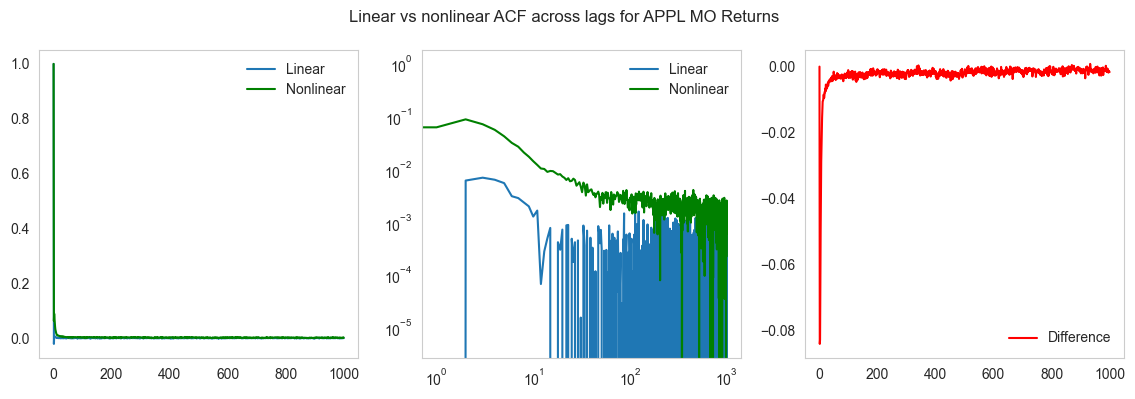

In [10]:
# Plot differences
for stock_name in linear_acfs.keys():
    plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs)

## 1.3. Test for Long Memory

To determine if a process exhibits long memory, we take the following approach:

1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

3. ** Estimate Hurst Exponent:** Use standard anf generalized hurst on raw series.


### 1.3.1. Estimate ACF scaling parameter

In [ ]:
tsla_returns_acf = nonlinear_acfs['TSLA']
x = list(range(1, len(tsla_returns_acf) + 1))
xy_df = pd.DataFrame({"x_values": x, "y_values": tsla_returns_acf})

tsla_acf_fit = Fit(xy_df)
tsla_acf_fit.powerlaw.fit_results()

### 1.3.2. Estimate Hurst Exponent

The Hurst Exponent, denoted by \(H\), is a statistical measure of a time series which can be used to determine the nature of the series. Its value can range between 0 and 1:

- \(H = 0.5\): The series is a random walk (Brownian motion). The future values do not depend on the past values.

- \(H < 0.5\): The series has a tendency to revert to a mean, indicating negative autocorrelation. This is typical of "mean-reverting" series.

- \(H > 0.5\): The series shows a trending behavior, meaning that increases (decreases) in the past will likely be followed by increases (decreases) in the future.


In [ ]:
# Estimate Hurst Exponent using both Standard and Generalized metod
tsla_returns = compute_returns(tsla_raw_df, T=100000)['cumsum_returns']

hurst_std, fit_std = standard_hurst(tsla_returns)
hurst_gen, fit_gen = generalized_hurst(tsla_returns)

fit_std.powerlaw.fit_results()
fit_gen.powerlaw.fit_results()
print(f"Standard Hurst Exponent: {hurst_std} ({interpret_hurst(hurst_std)})")
print(f"Generalized Hurst Exponent: {hurst_gen} ({interpret_hurst(hurst_gen)})")

In [ ]:
# Display the results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

# ACF
tsla_alpha = tsla_acf_fit.powerlaw.params.alpha
tsla_acf_fit.powerlaw.plot_fit(data_kwargs={"label": f"Alpha: {tsla_alpha:.2f}"}, fit_kwargs={"ax": axes[0]})

# Hurst
fit_std.powerlaw.plot_fit(data_kwargs={"label": f"Hurst: {hurst_std:.2f}"}, fit_kwargs={"ax": axes[1]})
fit_gen.powerlaw.plot_fit(data_kwargs={"label": f"Hurst: {hurst_gen:.2f}"}, fit_kwargs={"ax": axes[2]})

### 3.1.3. For all assets

In [ ]:
# Construct values for each dimension, x- and y-axis, of our ACF
def construct_xy(sample: pd.Series, name: str) -> pd.DataFrame:
    """
    Constructs x and y values for a given series and its name.

    Parameters:
    - sample: Series containing y values
    - name: String representing the series' name

    Returns:
    - DataFrame with columns 'x_values' and 'y_values'
    """
    y_values = list(sample)
    if len(sample) != len(y_values):
        raise ValueError(f"Sample sizes mismatch for {name}.")

    xy_df = pd.DataFrame({
        'x_values': range(1, len(y_values) + 1),
        'y_values': y_values
    })

    return xy_df

return_acf_values = {}

for stock, data in nonlinear_acfs.items():
    return_acf_values[stock] = construct_xy(data, stock)


tsla_cum_returns = compute_returns(tsla_raw_df, T=100000)['cumsum_returns']
amzn_cum_returns = compute_returns(amzn_raw_df, T=100000)['cumsum_returns']
nflx_cum_returns = compute_returns(nflx_raw_df, T=100000)['cumsum_returns']
msft_cum_returns = compute_returns(msft_raw_df, T=100000)['cumsum_returns']
ebay_cum_returns = compute_returns(ebay_raw_df, T=100000)['cumsum_returns']
appl_cum_returns = compute_returns(appl_raw_df, T=100000)['cumsum_returns']


cumsum_returns = {
  'TSLA': tsla_cum_returns,
  'AMZN': amzn_cum_returns,
  'NFLX': nflx_cum_returns,
  'MSFT': msft_cum_returns,
  'EBAY': ebay_cum_returns,
  'APPL': appl_cum_returns
}

# Iterate over each stock's ACF values
fit_results_list = []

# Iterate over each stock's ACF values and cumsum_returns
for stock, acf_values in return_acf_values.items():
    fit = Fit(acf_values)
    if hasattr(fit, 'powerlaw'):
        fit_dict = fit.powerlaw.to_dictionary()

        # Filter only if the function_name is 'powerlaw'
        if fit_dict.get("function_name") == "powerlaw":

            # Extract 'alpha' and other parameters directly
            alpha = fit.powerlaw.params.alpha
            C = fit.powerlaw.params.C

            # Compute Hurst Exponents for the cumsum_returns of the stock
            cum_returns = cumsum_returns[stock]
            hurst_std, fit_std = standard_hurst(cum_returns)
            hurst_gen, fit_gen = generalized_hurst(cum_returns)

            # Update the dictionary
            fit_dict.update({
                'alpha': alpha,
                'C': C,
                'hurst_std': hurst_std,
                'hurst_gen': hurst_gen,
                'stock': stock
            })

            fit_results_list.append(fit_dict)

In [ ]:
# Convert the list of dictionaries into a dataframe
fit_results = pd.DataFrame(fit_results_list)
fit_results